In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [2]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Displaying the created weights fo
# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals","Amphibians","Bird"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}

for scenario in scenarios:
    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []
    


    for sdm in sdms:
        mean_newvalue_hist[scenario][sdm] = {}
        mean_newvalue_fut[scenario][sdm] = {}
        mean_sumbin_hist[scenario][sdm] = {}
        mean_sumbin_fut[scenario][sdm] = {}
        
        dataarrays_newvalue_hist = []
        dataarrays_newvalue_fut = []
        dataarrays_sumbin_hist = []
        dataarrays_sumbin_fut = []

        for gcm in gcms:
            mean_newvalue_hist[scenario][sdm][gcm] = {}
            mean_newvalue_fut[scenario][sdm][gcm] = {}
            mean_sumbin_hist[scenario][sdm][gcm] = {}
            mean_sumbin_fut[scenario][sdm][gcm] = {}
            
            sum_newvalue_hist = None
            sum_newvalue_future = None
            sum_sumbin_hist = None
            sum_sumbin_future = None

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pickle.load(f)

     # Sum across taxa
                if sum_newvalue_hist is None:
                    sum_newvalue_hist = newvalue_hist_taxa
                    sum_newvalue_future = newvalue_future_taxa
                    sum_sumbin_hist = sum_bin_hist_taxa
                    sum_sumbin_future = sum_bin_future_taxa
                else:
                    sum_newvalue_hist += newvalue_hist_taxa
                    sum_newvalue_future += newvalue_future_taxa
                    sum_sumbin_hist += sum_bin_hist_taxa
                    sum_sumbin_future += sum_bin_future_taxa
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                    
            # Assign the summed values to your dictionary
            mean_newvalue_hist[scenario][sdm][gcm] = sum_newvalue_hist
            mean_newvalue_fut[scenario][sdm][gcm] = sum_newvalue_future
            mean_sumbin_hist[scenario][sdm][gcm] = sum_sumbin_hist
            mean_sumbin_fut[scenario][sdm][gcm] = sum_sumbin_future

            dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][sdm][gcm])
            dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][sdm][gcm])
            dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][sdm][gcm])
            dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][sdm][gcm])

        # Concatenate and calculate the mean over the new dimension
        mean_over_sdms_gcms_hist[scenario][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_fut[scenario][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_hist[scenario][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_fut[scenario][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

               # Append the mean DataArrays across GCMs to the SDM lists
        dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][sdm])
        dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][sdm])
        dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][sdm])
        dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][sdm])

    # Concatenate and calculate the mean over SDMs
    mean_over_all_sdms_gcms_hist[scenario] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_fut[scenario] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
    


In [3]:
#get the IPBES sub regions
# Read the shapefile

shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir)

# Define the region mapping
region_mapping = {
    'Carribean': 'Caribbean & Mesoamerica',
    'Central Africa': 'West, Central, East & South Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central, North-East & South Asia',
    'East Africa and adjacent islands': 'West, Central, East & South Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'Caribbean & Mesoamerica',
    'North Africa': 'North Africa & Western Asia',
    'North America': 'North America',
    'Nort-East Asia': 'Central, North-East & South Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'Central, North-East & South Asia',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'West, Central, East & South Africa',
    'West Africa': 'West, Central, East & South Africa',
    'Western Asia': 'North Africa & Western Asia'
}

# Create the new_region column in the shapefile
shp['new_region'] = shp['Sub_Region'].map(region_mapping)

#

In [22]:
import matplotlib as mpl
def set_plot_param():

    """Set my own customized plotting parameters"""

    import matplotlib as mpl

    mpl.rc('axes',edgecolor='grey')

    mpl.rc('axes',labelcolor='black')

    mpl.rc('xtick',color='black')

    mpl.rc('xtick',labelsize=22)

    mpl.rc('ytick',color='black')

    mpl.rc('ytick',labelsize=22)

    mpl.rc('axes',titlesize=22)

    mpl.rc('axes',labelsize=22)

    mpl.rc('legend',fontsize='large')

    mpl.rc('text',color='black')
    


    

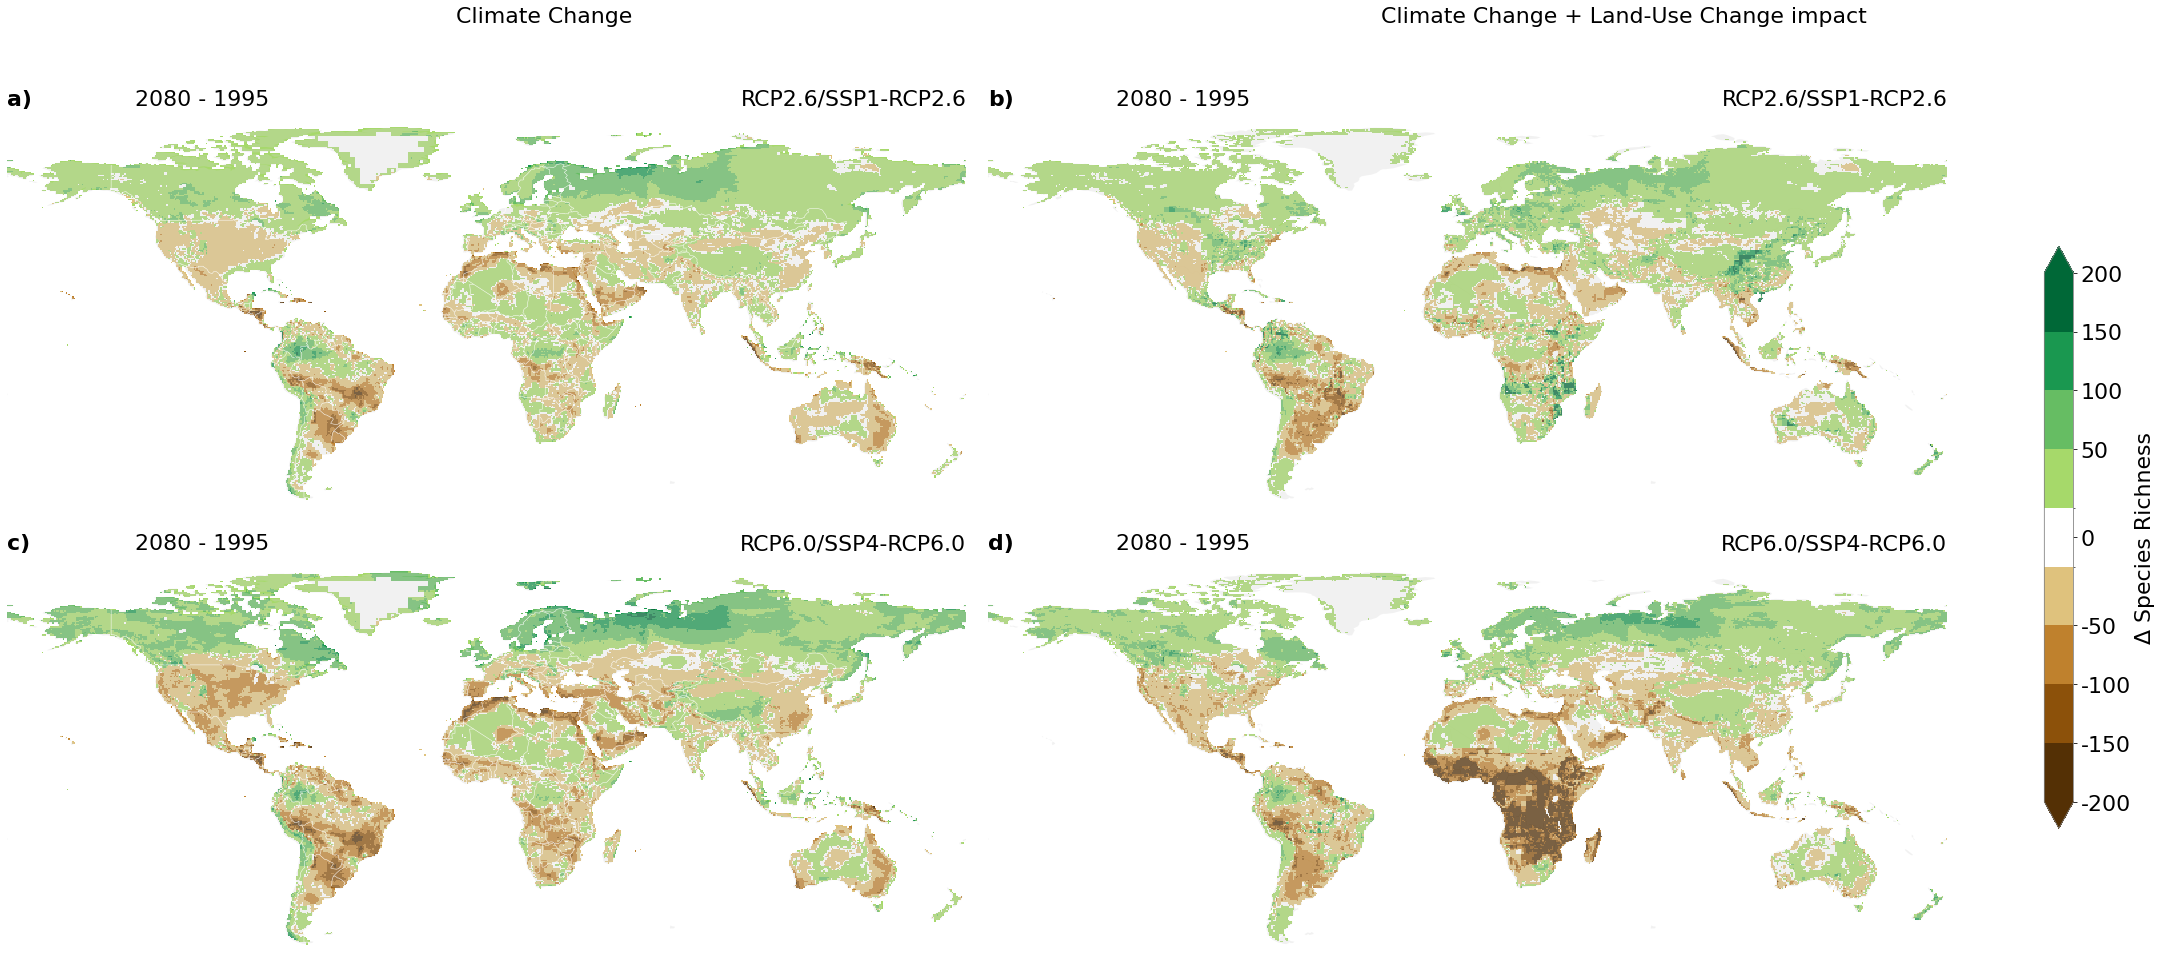

In [26]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

set_plot_param()
scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

scenario_indices={"rcp26": 'RCP2.6/SSP1-RCP2.6', "rcp60": 'RCP6.0/SSP4-RCP6.0'}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
subplot_labels = ['a)', 'b)','c)','d)']
for scenario in scenarios:
    diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
    diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]
    labels = [subplot_labels[plot_idx], subplot_labels[plot_idx + 1]]
    
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values
    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffff', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'] RdYlGn but white in the middle 

    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#ffffff', '#a6d96a', '#66bd63', '#1a9850', '#006837'] #RdYlGn but white in the middle and only 8 + white
    
    
    #custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'] #brown to blue
    custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#ffffff', '#a6d96a', '#66bd63', '#1a9850', '#006837'] # brown to green
    #custom_colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#ffffff', '#c7eae5', '#80cdc1', '#35978f', '#01665e'] # brown to turqois
    cmap = ListedColormap(custom_colors)

    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center',fontsize=18 )

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
    ax1.set_title(labels[0],loc='left',weight='bold')
    
    ax1.set_title(f" {year_indices[future_time]} - 1995",loc='center', x=0.2)
    
    
    ax1.set_title(f"{scenario_indices[scenario]}",loc='right')

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

  
    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f" {year_indices[future_time]} - 1995",loc='center', x=0.2)
    
    
    ax2.set_title(f"{scenario_indices[scenario]}",loc='right')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    ax2.set_title(labels[1],loc='left', weight='bold')




    #
    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2
#cbar = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05,extend='both')
cbar.set_label('Δ Species Richness')
ticks = np.array([-200, -150, -100, -50, 0, 50, 100, 150, 200])
tick_labels = ['-200', '-150', '-100', '-50', '0', '50', '100', '150', '200']

# Setzen Sie die Ticks und Tick-Labels für die Farbleiste
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

fig.text(0.75, 0.85, 'Climate Change + Land-Use Change impact', ha='center', fontsize=22)

# "Climate Change" über den linken oberen Subplot
fig.text(0.25, 0.85, 'Climate Change', ha='center', fontsize=22)

# Show or save the plot
plt.show()


In [7]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) /  sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)



diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.000000  0.000000
Central, North-East & South Asia   -0.512103 -1.615082
West, Central, East & South Africa -0.898394 -3.205959
Central and Western Europe          3.005970  2.852431
North Africa & Western Asia        -3.478815 -5.493665
South America                      -2.072944 -5.111695
Eastern Europe                      6.229027  8.626136
Oceania                            -1.567497 -3.434428
Caribbean & Mesoamerica            -2.873765 -6.989283
South-East Asia                     0.013951 -0.516741
North America                       4.404284  5.708216

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26      rcp60
NaN                                 0.000000   0.000000
Central, North-East & South Asia    1.044994  -4.305691
West, Central, East & South Africa  0.868136 -30.241

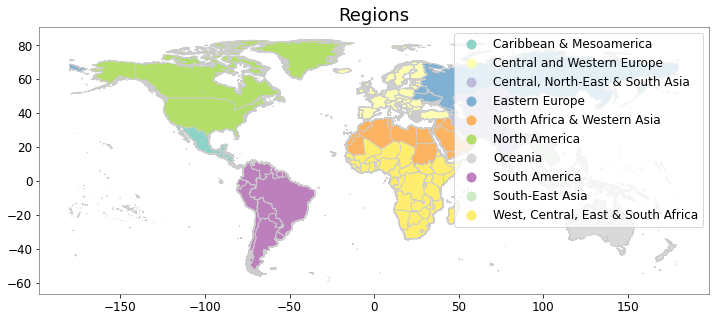

In [10]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame with a colormap based on the 'new_region' column
fig, ax = plt.subplots(figsize=(12, 12))
shp.plot(column='new_region', cmap='Set3', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set plot title
plt.title('Regions')

# Show the plot
plt.show()


In [14]:
# Define a dictionary for region abbreviations
region_abbreviations = {
    'Caribbean & Mesoamerica': 'CMA',
    'West, Central, East & South Africa': 'WCESA',
    'Central and Western Europe': 'CWE',
    'Central, North-East & South Asia': 'CNESA',
    'Eastern Europe': 'EE',
    'North Africa & Western Asia': 'NAWA',
    'North America': 'NA',
    'Oceania': 'OCE',
    'South America': 'SAM',
    'South-East Asia': 'SEA'
}

# Create a new column for abbreviated regions
shp['abbreviated_region'] = shp['new_region'].map(region_abbreviations)


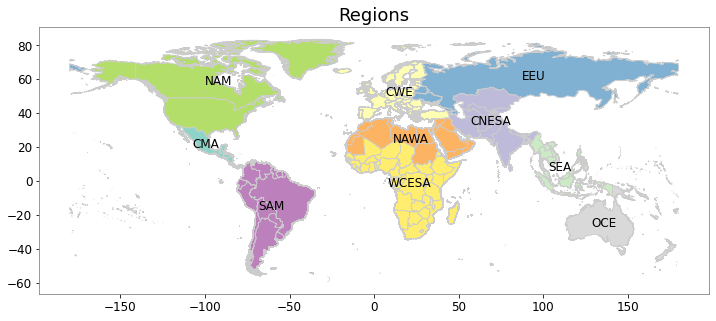

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming shp is your GeoDataFrame and it's already been loaded correctly.
# Define a dictionary for region abbreviations
region_abbreviations = {
    'Caribbean & Mesoamerica': 'CMA',
    'West, Central, East & South Africa': 'WCESA',
    'Central and Western Europe': 'CWE',
    'Central, North-East & South Asia': 'CNESA',
    'Eastern Europe': 'EEU',
    'North Africa & Western Asia': 'NAWA',
    'North America': 'NAM',
    'Oceania': 'OCE',
    'South America': 'SAM',
    'South-East Asia': 'SEA'
}

# Create a new column for abbreviated regions
shp['abbreviated_region'] = shp['new_region'].map(region_abbreviations)

# Group by the new_region and calculate the centroid of the geometries in each group
centroid_data = shp.dissolve(by='new_region').centroid
set_plot_param()
# Plot the GeoDataFrame with a colormap based on the 'new_region' column
fig, ax = plt.subplots(figsize=(12, 12))
shp.plot(column='new_region', cmap='Set3', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)  # Turn off the legend

# Set plot title
plt.title('Regions')

# Add labels for abbreviated regions at the centroid of each region
for region, point in centroid_data.items():
    ax.text(point.x, point.y, region_abbreviations[region], fontsize=12, ha='center', va='center')

# Show the plot
plt.show()
